In [1]:
import os
import gc
import re
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#from sklearn.externals import joblib

import matplotlib.pyplot as plt 
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
pd.read_csv('../../../home-credit-default-risk/HomeCredit_columns_description.csv',index_col=0)

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [3]:
feature_importances = pd.read_csv('feature_importance_model_gender_shuffle.csv')

In [4]:
feature_importances.head()

,feature,gain,split
0,EXT_SOURCES_MEAN,629953.485172,1589.1
1,EXT_SOURCES_NANMEDIAN,288911.861575,1371.0
2,EXT_SOURCES_MIN,232210.820724,1339.0
3,ORGANIZATION_TYPE,183190.129665,7011.4
4,EXT_SOURCES_MAX,130938.031831,1060.7


In [5]:
decisions = pd.read_csv('oof_model_gender_shuffle.csv')

In [6]:
decisions[['SK_ID_CURR','TARGET','PREDICTIONS']].head()

,SK_ID_CURR,TARGET,PREDICTIONS
0,100002,1.0,0.266254
1,100003,0.0,0.013986
2,100004,0.0,0.023005
3,100006,0.0,0.037812
4,100007,0.0,0.046390


In [7]:
submission = pd.read_csv('submission_model_gender_shuffle.csv')

In [8]:
test = pd.read_csv('../../../home-credit-default-risk/application_test.csv')
train = pd.read_csv('../../../home-credit-default-risk/application_train.csv')

In [9]:
train.shape, test.shape

((307511, 122), (48744, 121))

In [10]:
data = train.merge(decisions[['SK_ID_CURR','PREDICTIONS']],on='SK_ID_CURR',how='left')
test = test.merge(submission[['SK_ID_CURR','TARGET']],on='SK_ID_CURR',how='left')

In [11]:
data.shape, test.shape

((307511, 123), (48744, 122))

In [12]:
data.dropna(subset=['PREDICTIONS'],axis=0,inplace=True)

In [13]:

# Libraries to study
#from aif360.datasets import StandardDataset
#from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
#from aif360.algorithms.preprocessing import LFR, Reweighing
#from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
#from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

# ML libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Part I:  Analyze the effectiveness (accuracy) of the ADS by comparing its performance across different subpopulations.

There are several sub-populations of interest we explore.


In [14]:
# Compute AUC

roc_auc_score(data['TARGET'],data['PREDICTIONS'])

0.7986281965731116

This is the overall AUC score achieved. Now we want to compare how different sub-populations do on this. 


In [15]:
def subpopulation_AUC(data,col='CODE_GENDER',protected = 'F',continuous=False):
    """
    Compare model performance across subpopulations compared to the overall performance. 
    
    Since AUC is the target metric of this ADS, we will use this value to start for comparison. 
    
    
    """
    
    if continuous:
        unpriviledged_group = data.loc[data[col] >= protected]
    else:
        unpriviledged_group = data.loc[data[col] == protected] 

    unpriveledged_auc = roc_auc_score(unpriviledged_group['TARGET'],unpriviledged_group['PREDICTIONS'])
    overall_auc = roc_auc_score(data['TARGET'],data['PREDICTIONS'])

    
    return unpriveledged_auc,  unpriveledged_auc - overall_auc








In [16]:
subpopulation_AUC(data,col='CODE_GENDER',protected = 'F')


(0.7992866829979559, 0.0006584864248443401)

For gender, we observe that the ADS performs a little bit worse on the Female only sub-population. 

In [17]:
subpopulation_AUC(data,col='FLAG_OWN_CAR',protected = 'N')

(0.7987290927172851, 0.00010089614417352344)

For owning a car, we observe that this model ADS performs about the same regardless of this attribute. It is worth noting that this says nothing about the potential disparity between folks who own cars and those who don't, but this attribute does not impact evaluation performance. 

In [18]:
subpopulation_AUC(data,col='NAME_FAMILY_STATUS',protected = 'Widow')

(0.7702985957018802, -0.028329600871231375)

For the sub-population of widows, this model performs notably worse compared to the overall AUC. This could be an attribute worth exploring more. 

In [19]:
data.NAME_EDUCATION_TYPE.unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [20]:
subpopulation_AUC(data,col='NAME_EDUCATION_TYPE',protected = 'Lower secondary')

(0.7733506046001679, -0.025277591972943658)

For education, folks with a lower secondary degree also appear to be impacted negatively. 

In [21]:
data['CNT_CHILDREN'].unique()

array([ 0,  1,  2,  3,  4,  7,  5,  6,  8,  9, 11, 12, 10, 19, 14])

In [22]:
subpopulation_AUC(data,col='CNT_CHILDREN',protected = 1,continuous=True)


(0.8000050172664896, 0.001376820693378078)

Not entirely sure how to approach this for continuous values, but clearly there is some sort of disparity based on the number of children the applicant has, but it is certainly ambigiuous on what threshold to use. For now using 1, and we find that there is a slight difference between this group and overall. 

# Part II: Select one or several fairness or diversity measures, justify your choice of these measures for the ADS in question, and quantify the fairness or diversity of this ADS.

Now using the test set, we are exploring how if this ADS is deployed in the wild, to an extent, whether or not our fairness metrics help us identify any signficant disparities between sub-populations which are worth future auditing. 

In [23]:
test.rename(columns={"TARGET":"PREDICTIONS"},inplace=True)

In [24]:
def disparate_impact_calculator(data,col='CODE_GENDER',protected = 'F',continuous=False):
    
    if continuous:
        
        unpriviledged_group = data.loc[data[col] >= protected]
        priviledged_group = data.loc[data[col] < protected] 
        # a little ambiguous, but for some continuous values we could consider the protected class above, 
        # and the other below.
        # If not, just invert the recovered value!
        
    else: 
        
        unpriviledged_group = data.loc[data[col] == protected]
        priviledged_group = data.loc[data[col] != protected]

    return unpriviledged_group['PREDICTIONS'].mean()/priviledged_group['PREDICTIONS'].mean()

In [25]:
disparate_impact_calculator(test,col='CODE_GENDER',protected = 'F')

0.7228946704109036

In [26]:
disparate_impact_calculator(data,col='CODE_GENDER',protected = 'F')

0.7636249225977018

# This impact was slightly alleviated!

The ideal value for this attribute is 1. Not only do we observe a pretty significant deviation from this value, but we see that it gets worse when we move to test! 

In [27]:
disparate_impact_calculator(test,col='FLAG_OWN_CAR',protected = 'N')

1.1030948497130701

In [28]:
disparate_impact_calculator(data,col='FLAG_OWN_CAR',protected = 'N')

1.1521600724246586

Perhaps surpisingly, those who do not own cars are actually better off than those who do. There are a few explanations for this, but one hypothesis is that having a car means added expenses, thus making it less feasible for the applicant to pay a loan. 

In [29]:
disparate_impact_calculator(test,col='NAME_FAMILY_STATUS',protected = 'Widow')

0.6719221685992843

In [30]:
disparate_impact_calculator(data,col='NAME_FAMILY_STATUS',protected = 'Widow')

0.7041094851584311

The widow sub-population faces disparate impact. 

In [31]:
disparate_impact_calculator(test,col='NAME_EDUCATION_TYPE',protected = 'Lower secondary')

1.2640341635584056

In [32]:
disparate_impact_calculator(data,col='NAME_EDUCATION_TYPE',protected = 'Lower secondary')

1.3089180914564904

Much easier for lower secondary to receive favorable ratings than other groups. Why? 

In [33]:
disparate_impact_calculator(test,col='CNT_CHILDREN',protected = 1,continuous=True)


1.1228517036866072

In [34]:
disparate_impact_calculator(data,col='CNT_CHILDREN',protected = 1,continuous=True)


1.1481827472311983

A little bit of favor to those who have children, explanation could be that since these are typically older applicants, children are probably working, and as such, would be able to help support loan repayment if necessary. 

# Part III: Develop additional methods for analyzing ADS performance: think about stability, robustness, performance on difficult or otherwise important examples (in the style of LIME), or any other property that you believe is important to check for this ADS.

There are two things to consider for this ADS. First we want to take what were the sub-populations which demonstrated the most disparity from the measures above, and based on the system's feature importances, see if we can intuit as to why this might be the case, and based on that hypothesize on potential mitigation strategies from there. 


The next thing to understand are some local predictions, in particular for the most and least confident decisions made by the ADS.

The most confident scores will be prediction values near 0 or 1, and least confident will be predictions right around .5

In [62]:
data = pd.read_csv('../dat/challenge_final_df.csv',index_col=0)
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))




In [63]:
df = data[data['TARGET'].notnull()]

test = data[data['TARGET'].isnull()]

In [64]:
test.head(n=3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,FLOORSMAX_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,WALLSMATERIAL_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_8,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT,DOCUMENT_COUNT,NEW_DOC_KURT,AGE_RANGE,EXT_SOURCES_PROD,EXT_SOURCES_WEIGHTED,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,CREDIT_TO_INCOME_RATIO,INCOME_TO_EMPLOYED_RATIO,INCOME_TO_BIRTH_RATIO,EMPLOYED_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,GROUP_EXT_SOURCES_MEDIAN,GROUP_EXT_SOURCES_STD,GROUP_INCOME_MEAN,GROUP_INCOME_STD,GROUP_CREDIT_TO_ANNUITY_MEAN,GROUP_CREDIT_TO_ANNUITY_STD,GROUP_CREDIT_MEAN,GROUP_ANNUITY_MEAN,GROUP_ANNUITY_STD,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MEAN,BUREAU_DEBT_CREDIT_DIFF_MEAN,BUREAU_DEBT_CREDIT_DIFF_SUM,BUREAU_MONTHS_BALANCE_MEAN_MEAN,BUREAU_MONTHS_BALANCE_MEAN_VAR,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_STATUS_0_MEAN,BUREAU_STATUS_1_MEAN,BUREAU_STATUS_12345_MEAN,BUREAU_STATUS_C_MEAN,BUREAU_STATUS_X_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_TYPE_Consumercredit_MEAN,BUREAU_CREDIT_TYPE_Creditcard_MEAN,BUREAU_CREDIT_TYPE_Carloan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_LL_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LL_DEBT_CREDIT_DIFF_MEAN,BUREAU_LL_STATUS_12345_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_MAX,BUREAU_ACTIVE_DAYS_CREDIT_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN,BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN,BUREAU_ACTIVE_CREDIT_TO_ANNUITY_RATIO_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_VAR,BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_SUM,BUREAU_CLOSED_DAYS_CREDIT_MAX,BUREAU_CLOSED_DAYS_CREDIT_VAR,BUREAU_CLOSED_DAYS_CREDIT_ENDDATE_MAX,BUREAU_CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_CLOSED_AMT_CREDIT_SUM_MAX,BUREAU_CLOSED_AMT_CREDIT_SUM_MEAN,BUREAU_CLOSED_AMT_CREDIT_SUM_SUM,BUREAU_CLOSED_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_CLOSED_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_CLOSED_DAYS_CREDIT_UPDATE_MAX,BUREAU_CLOSED_ENDDATE_DIF_MEAN,BUREAU_

In [55]:
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, df.columns))


In [56]:
import lightgbm as lgb

In [47]:
clf = lgb.LGBMClassifier(model_file='final_model.pkl')


In [57]:
clf.fit(df[predictors],df['TARGET'])

[LightGBM] [Warning] Unknown parameter: model_file


LGBMClassifier(model_file='final_model.pkl')

In [67]:

#
clf.predict_proba(test[predictors].values[:3])[:, 1]

array([0.03448517, 0.1775465 , 0.0272911 ])

In [70]:
import lime
import lime.lime_tabular

In [88]:
test.fillna(-1).isna().sum()

SK_ID_CURR                                                   0
TARGET                                                       0
NAME_CONTRACT_TYPE                                           0
CODE_GENDER                                                  0
FLAG_OWN_CAR                                                 0
AMT_INCOME_TOTAL                                             0
AMT_CREDIT                                                   0
AMT_ANNUITY                                                  0
AMT_GOODS_PRICE                                              0
NAME_TYPE_SUITE                                              0
NAME_INCOME_TYPE                                             0
NAME_EDUCATION_TYPE                                          0
NAME_FAMILY_STATUS                                           0
NAME_HOUSING_TYPE                                            0
REGION_POPULATION_RELATIVE                                   0
DAYS_BIRTH                                             

In [84]:
df.isna().sum()

SK_ID_CURR                                                        0
TARGET                                                            0
NAME_CONTRACT_TYPE                                                0
CODE_GENDER                                                       0
FLAG_OWN_CAR                                                      0
AMT_INCOME_TOTAL                                                  0
AMT_CREDIT                                                        0
AMT_ANNUITY                                                      12
AMT_GOODS_PRICE                                                 278
NAME_TYPE_SUITE                                                   0
NAME_INCOME_TYPE                                                  0
NAME_EDUCATION_TYPE                                               0
NAME_FAMILY_STATUS                                                0
NAME_HOUSING_TYPE                                                 0
REGION_POPULATION_RELATIVE                      

In [82]:
test[predictors].isna().sum()

NAME_CONTRACT_TYPE                                               0
CODE_GENDER                                                      0
FLAG_OWN_CAR                                                     0
AMT_INCOME_TOTAL                                                 0
AMT_CREDIT                                                       0
AMT_ANNUITY                                                     24
AMT_GOODS_PRICE                                                  0
NAME_TYPE_SUITE                                                  0
NAME_INCOME_TYPE                                                 0
NAME_EDUCATION_TYPE                                              0
NAME_FAMILY_STATUS                                               0
NAME_HOUSING_TYPE                                                0
REGION_POPULATION_RELATIVE                                       0
DAYS_BIRTH                                                       0
DAYS_EMPLOYED                                                 

In [86]:

explainer = lime.lime_tabular.LimeTabularExplainer(df[predictors].fillna(-1).values,
                                                   #class_names = class_names, 
                                                   mode = "classification",
                                                   feature_names = predictors,
                                                   random_state = 42,
                                                   verbose = True)

/scratch/nsk367/anaconda3/envs/ads/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/scratch/nsk367/anaconda3/envs/ads/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
# most confident prediction for train
decisions.loc[decisions['PREDICTIONS'] == data['PREDICTIONS'].min()].in

In [ ]:
decisions.loc[decisions['PREDICTIONS'] == data['PREDICTIONS'].max()]

In [ ]:
decisions.loc[decisions['PREDICTIONS'] == .5] # TODO - find closest 

TODO- save submissiuon features, and compute these high and low confidence values for the test set. I don't have that at the moment.  

In [ ]:
decisions.iloc[(decisions['PREDICTIONS']-.5).abs().argsort()[:1]]

Also need the model itself, which I currently do not have saved! 

In the event that we do not get LIME working, another important aspect for transparency is to look at the provided feature importances, and allow that to guide our understanding of this ADS.

In [91]:
feature_importances.head()

,feature,gain,split
0,EXT_SOURCES_MEAN,630312.097774,1627.9
1,EXT_SOURCES_NANMEDIAN,288492.997356,1361.8
2,EXT_SOURCES_MIN,232531.100522,1376.2
3,ORGANIZATION_TYPE,184313.908802,7139.4
4,EXT_SOURCES_MAX,131637.630816,1076.7


In [92]:
feature_importances.loc[feature_importances['feature'].str.contains("GENDER")]

,feature,gain,split
25,CODE_GENDER,26347.336944,530.7


In [94]:
26 / 657

0.0395738203957382

In the top 4% of features. 

Other potential sources of disparity? Let's look at the different kinds of data streams contributing to the top. 

In [98]:
feature_importances['feature_class'] = feature_importances['feature'].apply(lambda z: '_'.join(z.split('_')[:-1]))

In [99]:
feature_importances.head()

,feature,gain,split,feature_class
0,EXT_SOURCES_MEAN,630312.097774,1627.9,EXT_SOURCES
1,EXT_SOURCES_NANMEDIAN,288492.997356,1361.8,EXT_SOURCES
2,EXT_SOURCES_MIN,232531.100522,1376.2,EXT_SOURCES
3,ORGANIZATION_TYPE,184313.908802,7139.4,ORGANIZATION
4,EXT_SOURCES_MAX,131637.630816,1076.7,EXT_SOURCES


<AxesSubplot:>

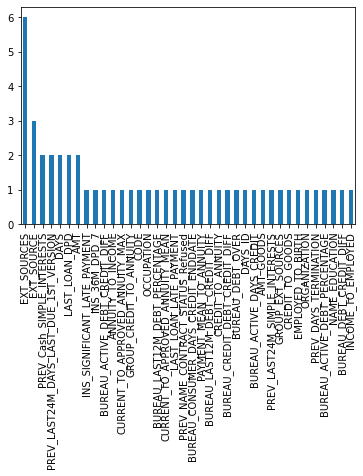

In [101]:
feature_importances.head(n=50)['feature_class'].value_counts().plot(kind='bar')